In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [6]:
df = pd.read_excel("/content/drive/MyDrive/Healthcare_premium_pred/datasets/premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [7]:
df['Genetical_Risk']=0

In [8]:
df.shape

(29904, 14)

In [9]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

In [10]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0


### Handle NA values

In [11]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,9
employment_status,1
income_level,9
income_lakhs,0


In [12]:
df.dropna(inplace=True)
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,0
employment_status,0
income_level,0
income_lakhs,0


### Handle Duplicate Values

In [13]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [14]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


In [15]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [16]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

,number_of_dependants
count,29886.000000
mean,2.385933
std,1.421137
min,0.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,5.000000


### Outlier Detection

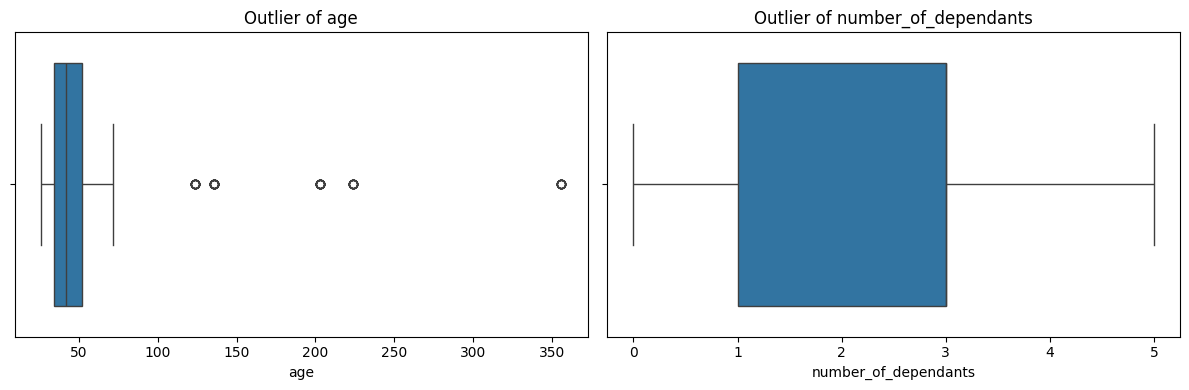

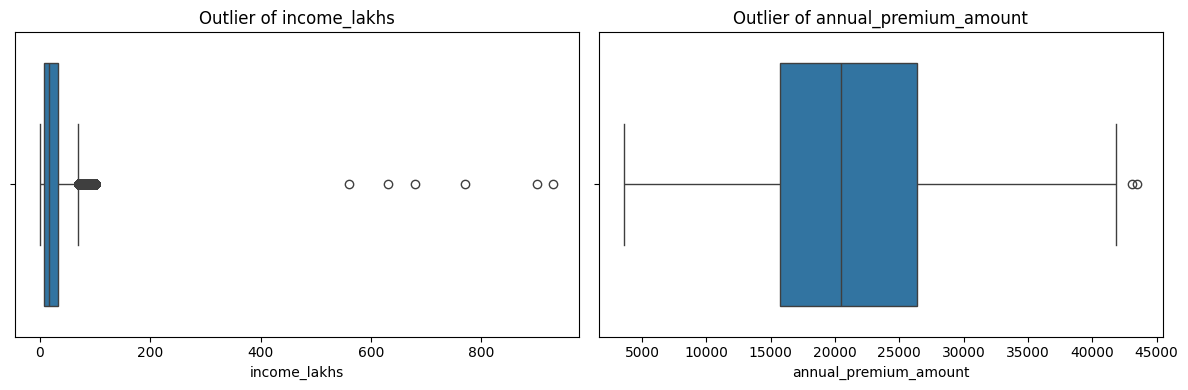

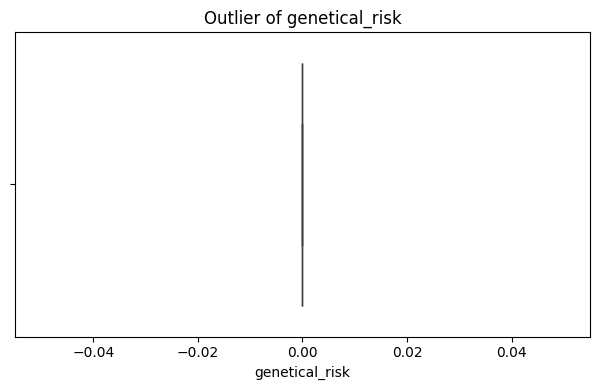

In [17]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

for i in range(0, len(numeric_cols), 2):
    plt.figure(figsize=(12, 4))

    # First plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[numeric_cols[i]])
    plt.title(f"Outlier of {numeric_cols[i]}")

    # Second plot (if exists)
    if i + 1 < len(numeric_cols):
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[numeric_cols[i + 1]])
        plt.title(f"Outlier of {numeric_cols[i + 1]}")

    plt.tight_layout()
    plt.show()


In [18]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [19]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


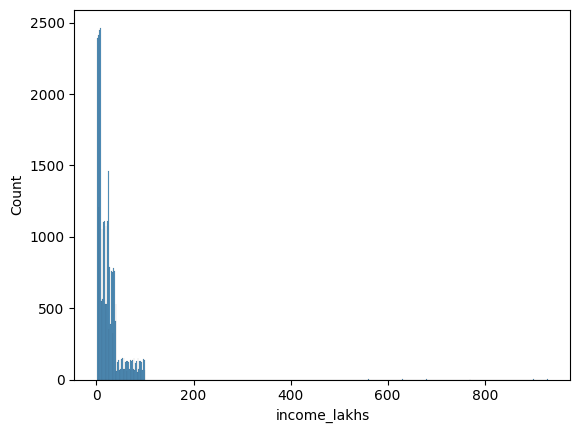

In [20]:
sns.histplot(df1['income_lakhs'])
plt.show()

In [21]:
def get_iqr_bounds(col):
  Q1, Q3 = col.quantile([0.25, 0.75])
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return lower_bound, upper_bound

In [22]:
get_iqr_bounds(df1['income_lakhs'])

(-30.5, 69.5)

In [23]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [24]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


### Dataset skeww check

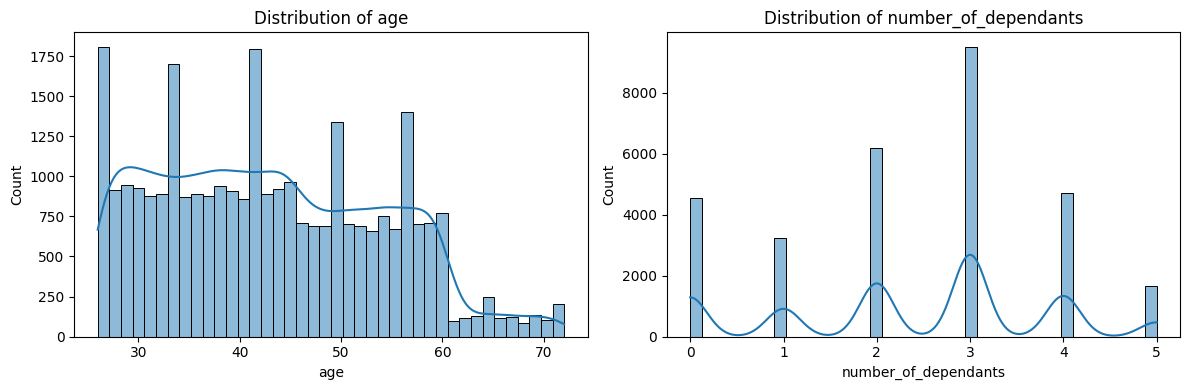

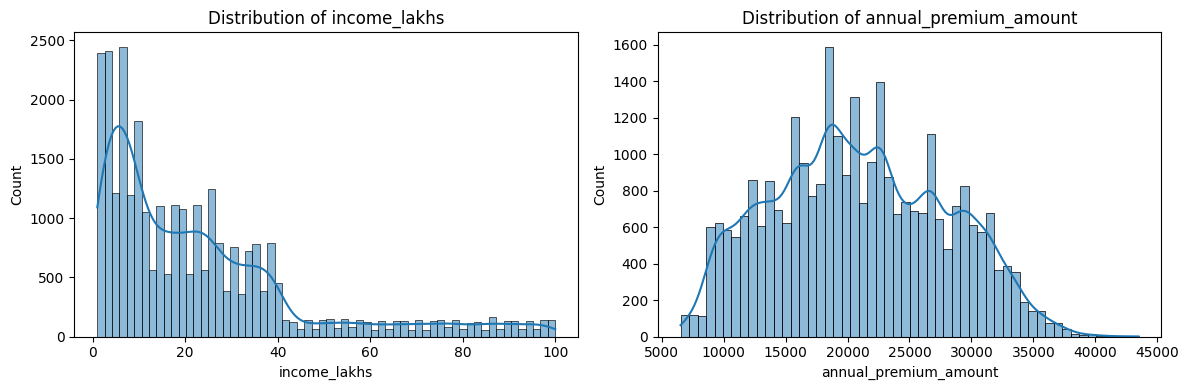

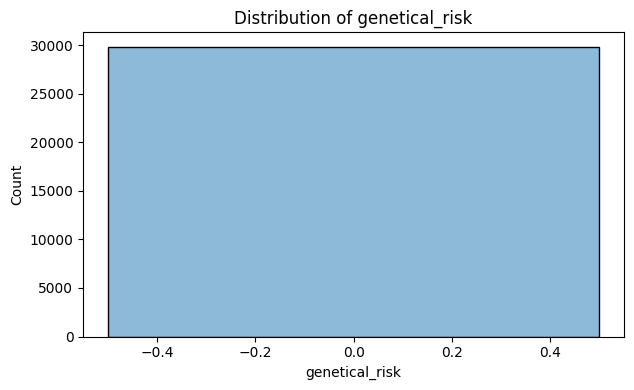

In [25]:
numeric_cols = [col for col in df2.columns if df2[col].dtype in ['int64', 'float64']]

# Loop through 2 at a time
for i in range(0, len(numeric_cols), 2):
    plt.figure(figsize=(12, 4))

    # First histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df2[numeric_cols[i]], kde=True)
    plt.title(f"Distribution of {numeric_cols[i]}")

    # Second histogram (if it exists)
    if i + 1 < len(numeric_cols):
        plt.subplot(1, 2, 2)
        sns.histplot(df2[numeric_cols[i + 1]], kde=True)
        plt.title(f"Distribution of {numeric_cols[i + 1]}")

    plt.tight_layout()
    plt.show()

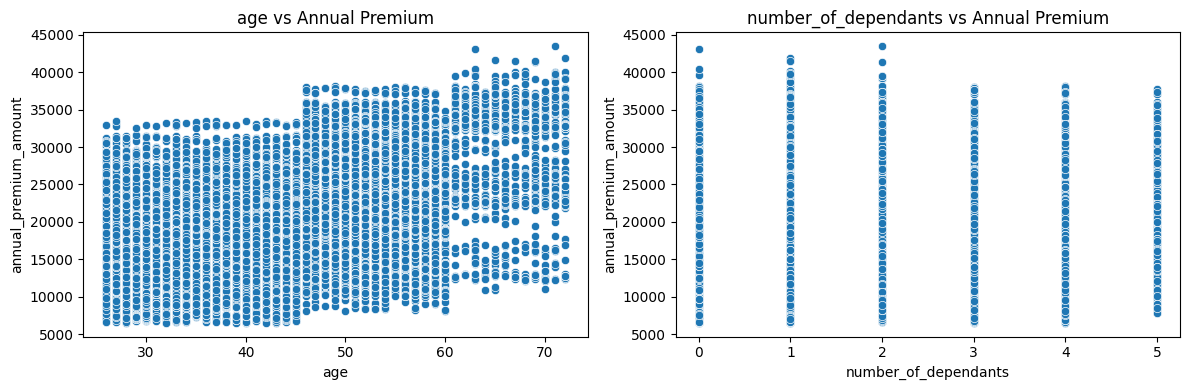

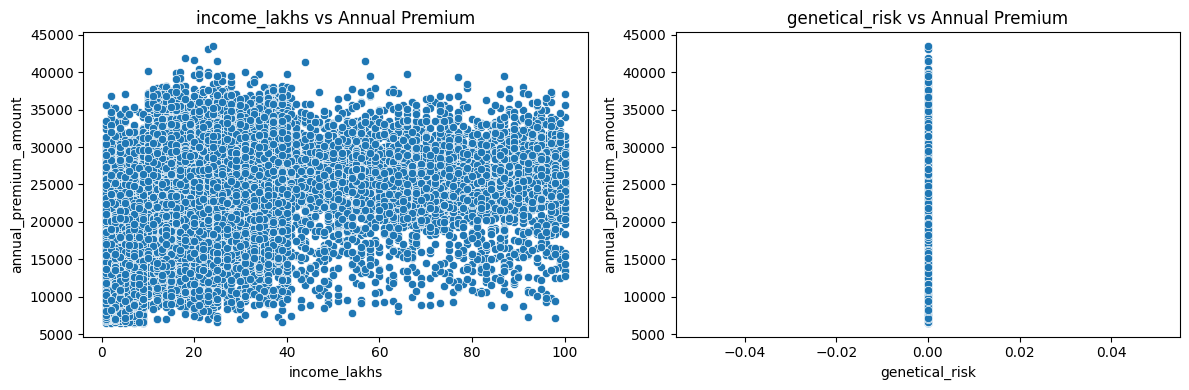

In [26]:
# Get all numeric columns except 'annual_premium_amount'
numeric_cols = [col for col in df2.columns if df2[col].dtype in ['int64', 'float64'] and col != 'annual_premium_amount']

# Loop and plot
for i in range(0, len(numeric_cols), 2):
    plt.figure(figsize=(12, 4))

    # First plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df2, x=numeric_cols[i], y='annual_premium_amount')
    plt.title(f"{numeric_cols[i]} vs Annual Premium")

    # Second plot (if exists)
    if i + 1 < len(numeric_cols):
        plt.subplot(1, 2, 2)
        sns.scatterplot(data=df2, x=numeric_cols[i + 1], y='annual_premium_amount')
        plt.title(f"{numeric_cols[i + 1]} vs Annual Premium")

    plt.tight_layout()
    plt.show()


In [27]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0


In [28]:
cat_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in cat_col:
  print(col,":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


### Dirty Read values in smoking_status...

In [29]:
df2['smoking_status'] = df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
})
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [30]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

,proportion
gender,
Male,0.549125
Female,0.450875


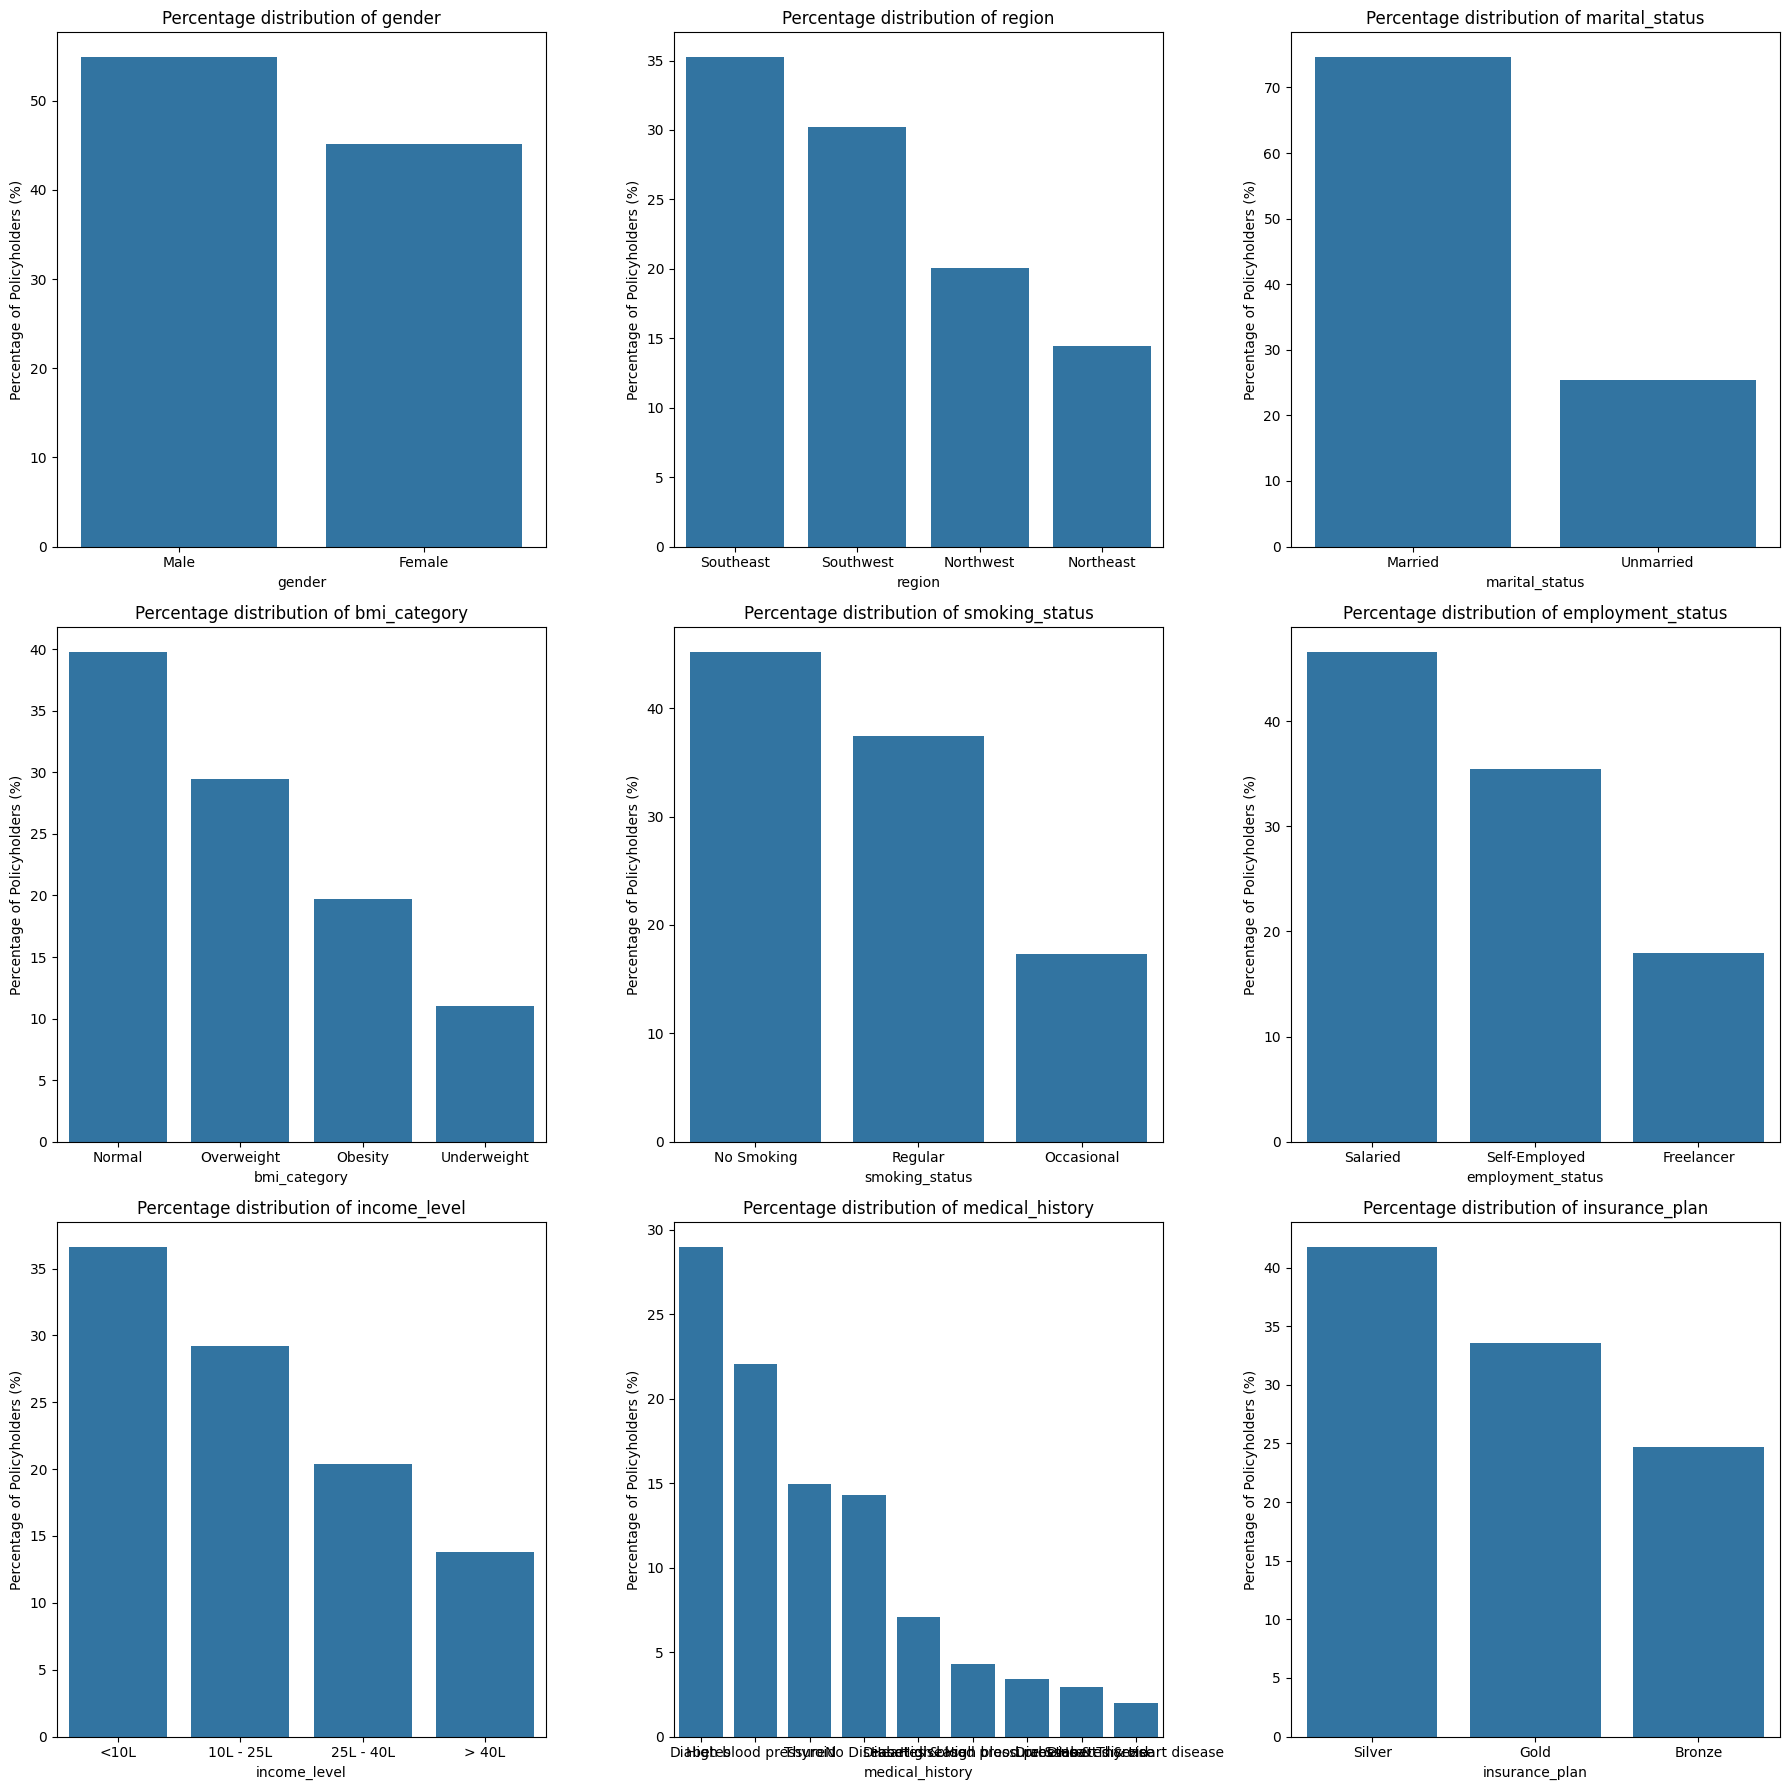

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for ax, column in zip(axes, cat_col):
  # Calculate the percentage distribution of each category.
  category_counts = df2[column].value_counts(normalize=True) * 100
  sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
  ax.set_title(f'Percentage distribution of {column}')
  ax.set_ylabel('Percentage of Policyholders (%)')
  ax.set_xlabel(column)

plt.tight_layout()
plt.show()


## Income vs Plan. --> Bivariate analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


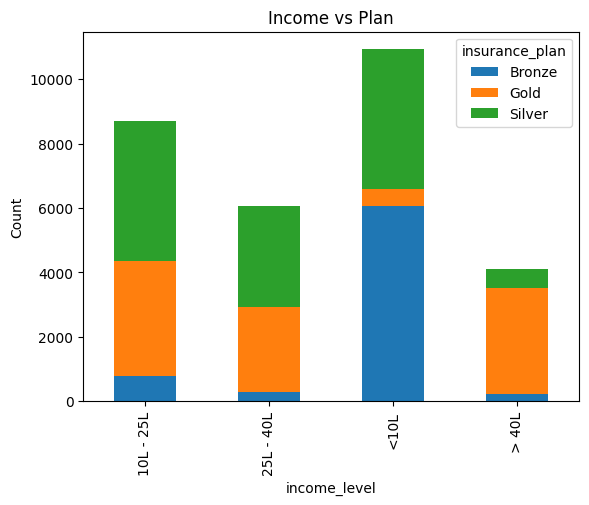

In [32]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)
plt.title("Income vs Plan")
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

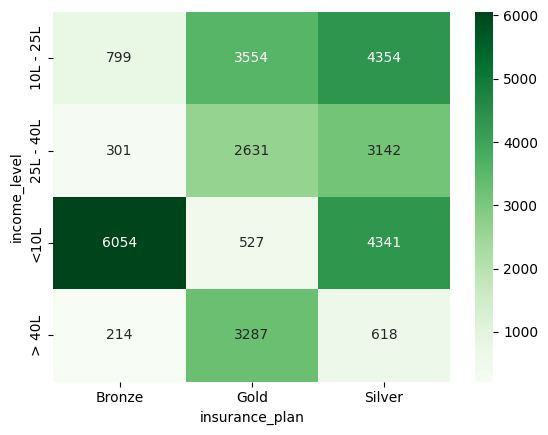

In [33]:
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Greens')

# <h1 style="color:blue;">Feature Engineering</h1>

In [34]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0


In [35]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [36]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None


In [37]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
26899,32,Male,Northwest,Married,3,Normal,Regular,Salaried,<10L,1,High blood pressure,Bronze,11590,0,high blood pressure,None
29594,54,Male,Southeast,Married,2,Overweight,No Smoking,Salaried,10L - 25L,20,Diabetes,Gold,28886,0,diabetes,None
14408,34,Female,Southeast,Married,3,Overweight,No Smoking,Self-Employed,25L - 40L,33,High blood pressure,Silver,17165,0,high blood pressure,None
18989,37,Female,Southwest,Married,4,Underweight,Regular,Salaried,<10L,3,Diabetes & High blood pressure,Bronze,15064,0,diabetes,high blood pressure
24270,47,Male,Northeast,Married,3,Overweight,No Smoking,Salaried,<10L,6,Thyroid,Bronze,12355,0,thyroid,None


# Working on risk factor according to the disease

In [38]:
risk_score = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}


In [39]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0


for disease in ['disease1', 'disease2']:
  df2['total_risk_score'] += df2[disease].map(risk_score)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(3)

/tmp/ipython-input-2959938099.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
/tmp/ipython-input-2959938099.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,none,6,0.428571


In [40]:
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
10396,33,Male,Southwest,Unmarried,0,Normal,Occasional,Salaried,10L - 25L,10,High blood pressure,Silver,16197,0,high blood pressure,none,6,0.428571
16698,38,Male,Northeast,Unmarried,1,Underweight,Regular,Self-Employed,> 40L,92,Diabetes,Silver,18846,0,diabetes,none,6,0.428571
4595,42,Male,Southeast,Unmarried,0,Normal,Regular,Salaried,<10L,8,High blood pressure,Bronze,11684,0,high blood pressure,none,6,0.428571


### Encoding Technique

In [41]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [42]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [43]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [44]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '> 40L': 4, '25L - 40L': 3})

In [45]:
df2['income_level'].unique()

array([1, 2, 4, 3])

In [46]:
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
28002,40,Male,Southeast,Married,3,Normal,Regular,Freelancer,1,9,Thyroid,1,11595,0,thyroid,none,5,0.357143
6617,62,Male,Southwest,Married,1,Normal,No Smoking,Self-Employed,4,90,Diabetes,3,32304,0,diabetes,none,6,0.428571
27632,29,Male,Northwest,Unmarried,1,Overweight,Regular,Freelancer,2,20,Diabetes & Thyroid,2,22315,0,diabetes,thyroid,11,0.785714


In [47]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,0,no disease,none,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,0,diabetes,none,...,0,0,0,1,0,0,1,0,0,1


In [48]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


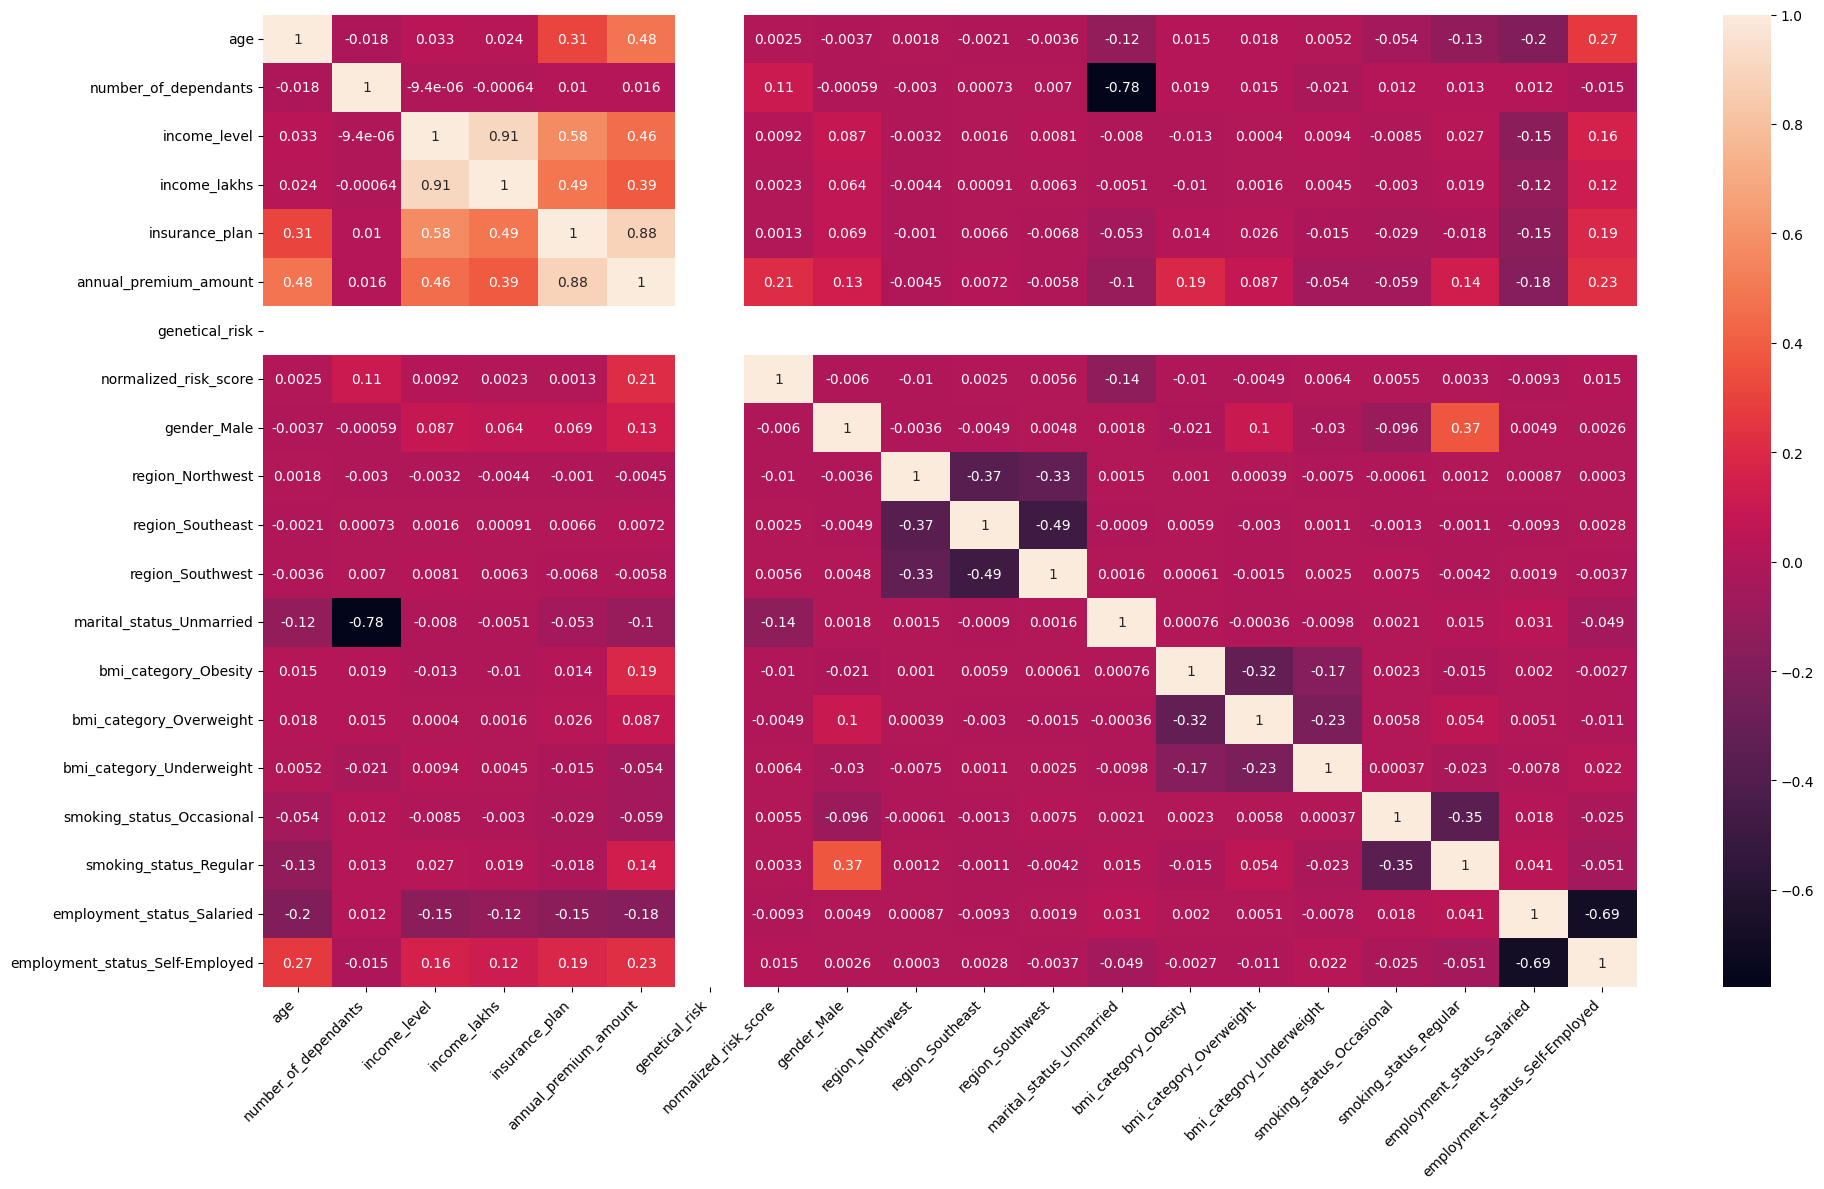

In [49]:
cm = df4.corr() # Call the corr() method to get the correlation matrix

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Scaling ->

In [50]:
df4.head(1)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0


In [51]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
  vif_df = pd.DataFrame()
  vif_df['Column'] = data.columns
  vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif_df

In [53]:
calculate_vif(X)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,normalized_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


In [54]:
calculate_vif(X.drop('income_level', axis='columns'))

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [55]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


# **Model Training ->**

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X train:", X_train.shape)
print("X test:", X_test.shape)
print("y train:", y_train.shape)
print("y test:", y_test.shape)

X train: (20875, 18)
X test: (8947, 18)
y train: (20875,)
y test: (8947,)




> train_score and test_score both are same, So there is not any case of Model overfitting.



In [57]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [58]:
model_lr.coef_

array([ 7.01623933e+03, -1.31176470e+03, -7.08193369e+02,  1.48359882e+04,
        6.82121026e-13,  6.05362412e+03,  3.75582688e+01, -5.52508721e+01,
       -1.96225429e+01, -2.22896756e+01, -7.00320200e+02,  3.92681271e+03,
        1.97945605e+03,  6.12866236e+02,  8.37395101e+02,  2.80066184e+03,
       -4.54913671e+01,  2.43078421e+02])

In [59]:
model_lr.intercept_

np.float64(5935.981289344609)

### Finding the Feature Participation among the training

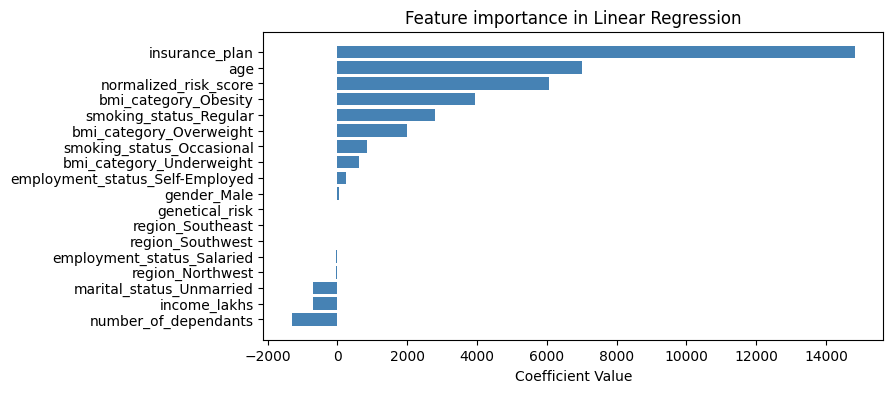

In [60]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature importance in Linear Regression')
plt.show()

In [61]:
alpha_rng = [1, 0.1, 10.0, 5, 0.01]

for alpha in alpha_rng:
    model_rg = Ridge(alpha=alpha)
    model_rg.fit(X_train, y_train)
    train_score = model_rg.score(X_train, y_train)
    test_score = model_rg.score(X_test, y_test)
    print(f'Training score for alpha {alpha}: {train_score:.2f} | Testing score: {test_score:.2f}')

Training score for alpha 1: 0.95 | Testing score: 0.95
Training score for alpha 0.1: 0.95 | Testing score: 0.95
Training score for alpha 10.0: 0.95 | Testing score: 0.95
Training score for alpha 5: 0.95 | Testing score: 0.95
Training score for alpha 0.01: 0.95 | Testing score: 0.95


In [62]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9986370801925659, 0.9979538321495056)

In [63]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_pred, y_test)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  96814.21875 RMSE:  311.1498332797239


In [64]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9977717598279318)

In [65]:
random_search.best_params_

{'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}

In [66]:
best_model = random_search.best_estimator_

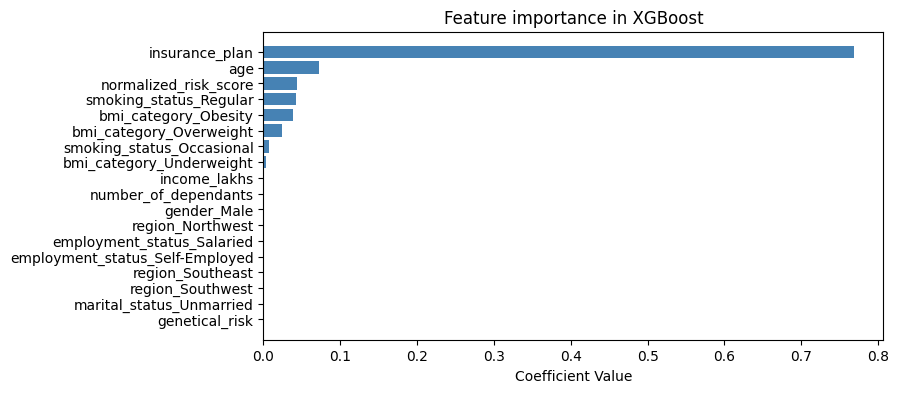

In [67]:
feature_importance = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature importance in XGBoost')
plt.show()



> XGBoost has given a good accuracy comparison to Linear Regression, but this feature importance is not good as compared to Linear_reg model.



## Error Analysis..

In [68]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

result_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

result_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26641.001953,-253.998047,-0.944406
14750,22734,22956.232422,222.232422,0.977533
19932,21198,21504.177734,306.177734,1.444371
29643,9100,9271.687500,171.687500,1.886676
17076,26434,26641.001953,207.001953,0.783090




> We can see here diff_pct for some values is too high, which is a big error.



<Axes: xlabel='diff_pct', ylabel='Count'>

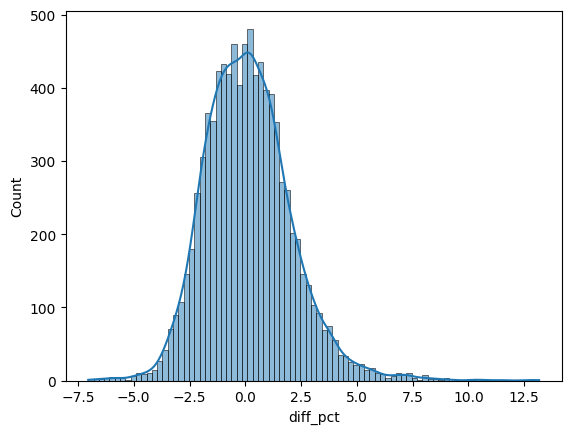

In [69]:
sns.histplot(result_df['diff_pct'], kde=True)

In [70]:
extreme_error_threshold = 10

extreme_result_df = result_df[np.abs(result_df.diff_pct)>extreme_error_threshold]
extreme_result_df.shape

(9, 4)

In [71]:
extreme_result_pct = extreme_result_df.shape[0]*100/result_df.shape[0]
extreme_result_pct

0.10059237733318431

In [72]:
result_df[np.abs(result_df['diff_pct']>50)].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [73]:
extreme_result_df.index

Index([7547, 21910, 12189, 8216, 21455, 10741, 6517, 13744, 11019], dtype='int64')

In [74]:
extreme_errors_df = X_test.loc[extreme_result_df.index]
extreme_errors_df.shape

(9, 18)

In [75]:
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
7547,0.347826,0.2,0.080808,0.0,0.0,0.0,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1,0
8216,0.152174,0.4,0.010101,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
21455,0.239130,0.2,0.080808,0.0,0.0,0.0,1,1,0,0,1,0,0,0,0,0,0,0


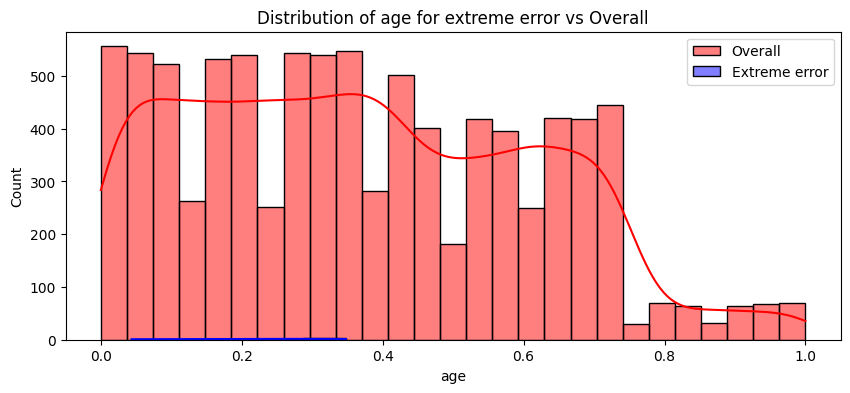

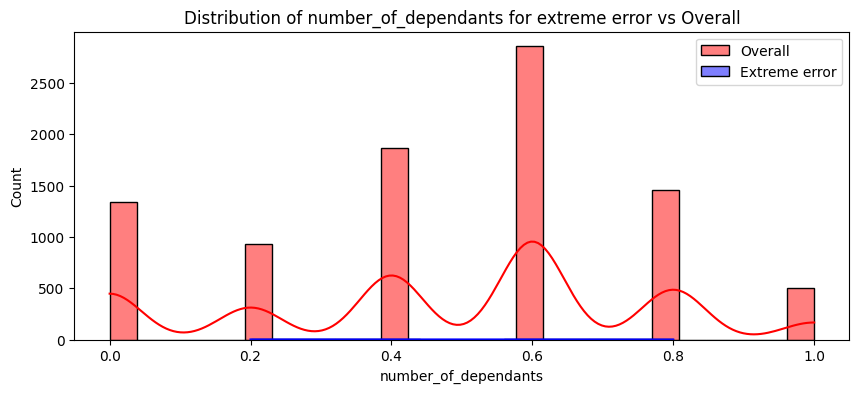

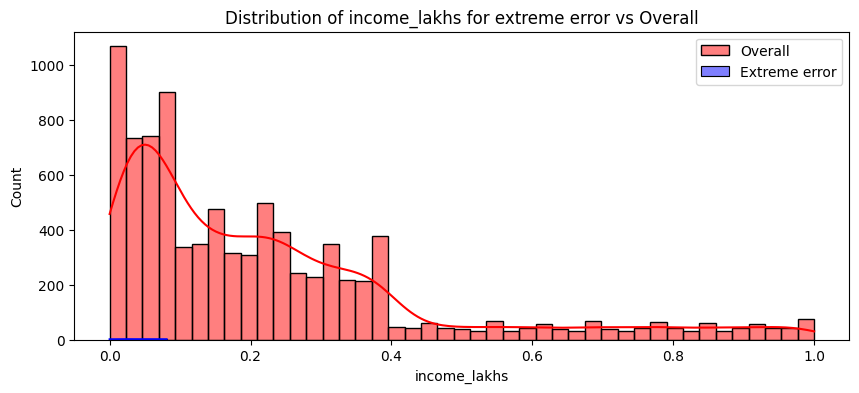

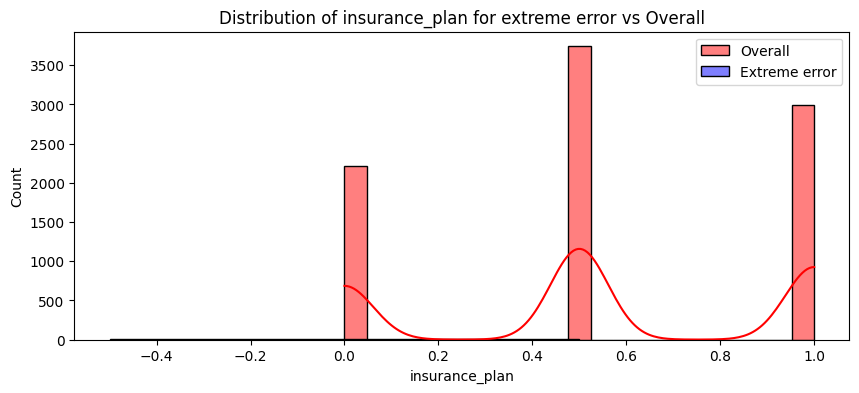

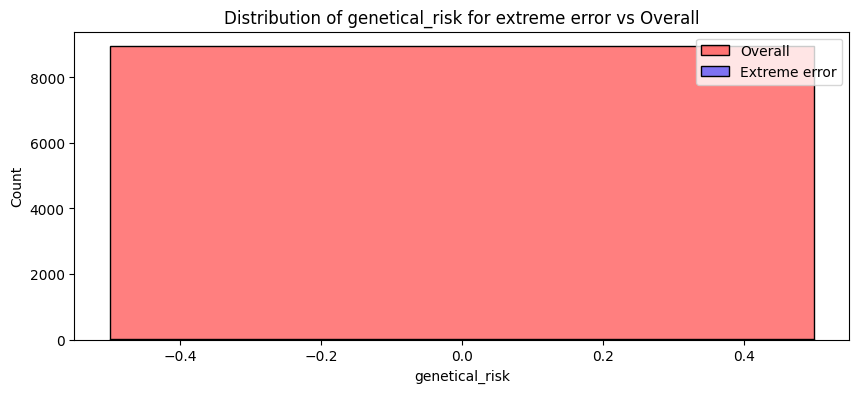

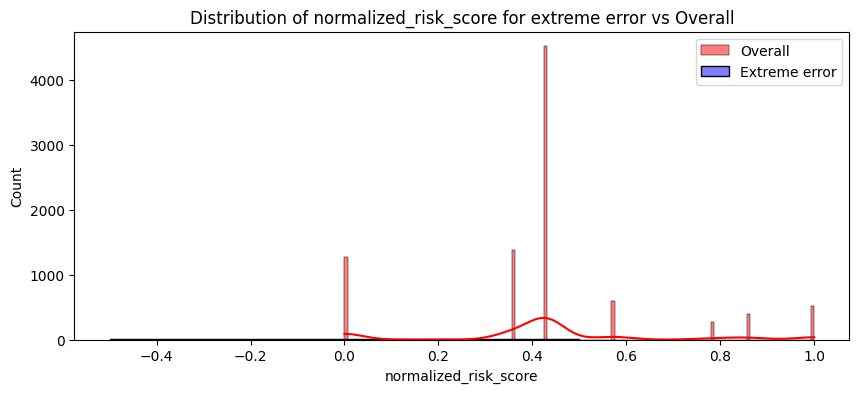

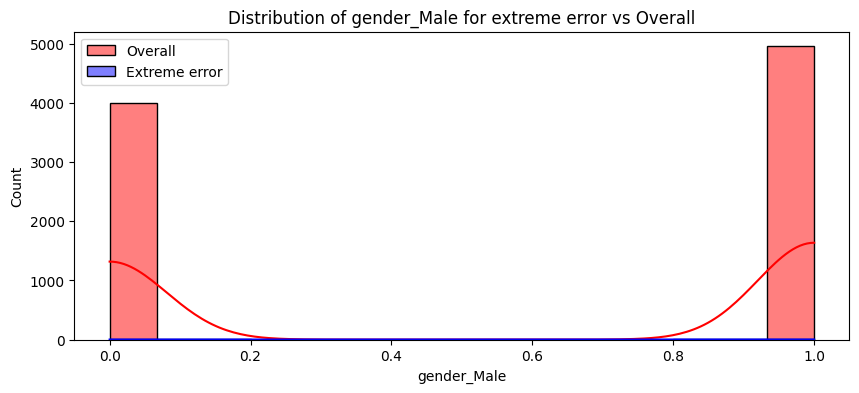

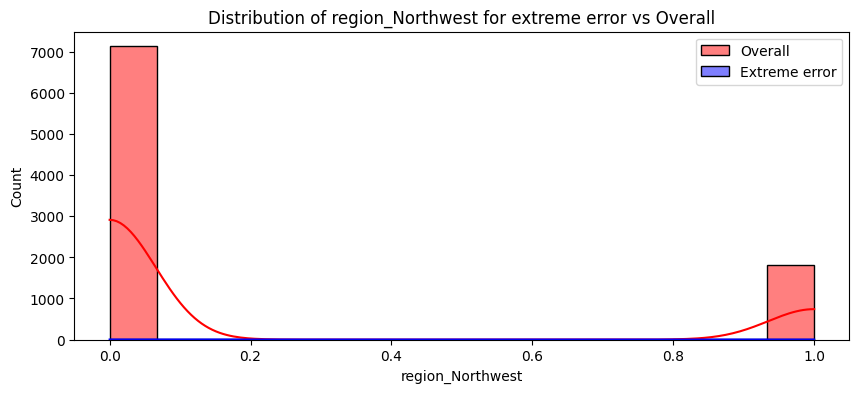

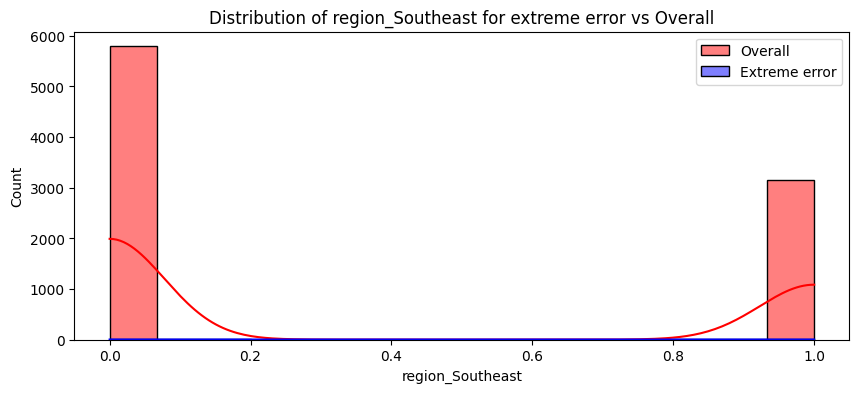

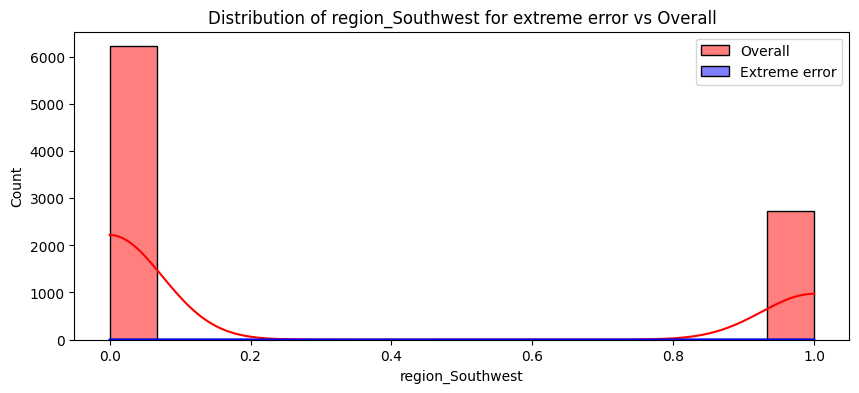

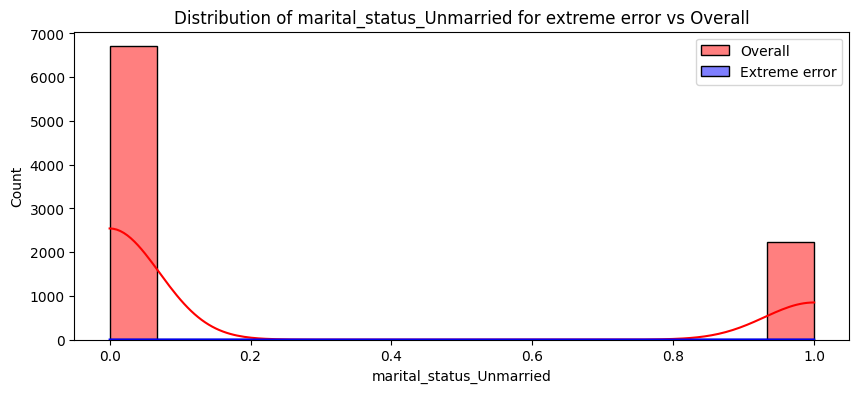

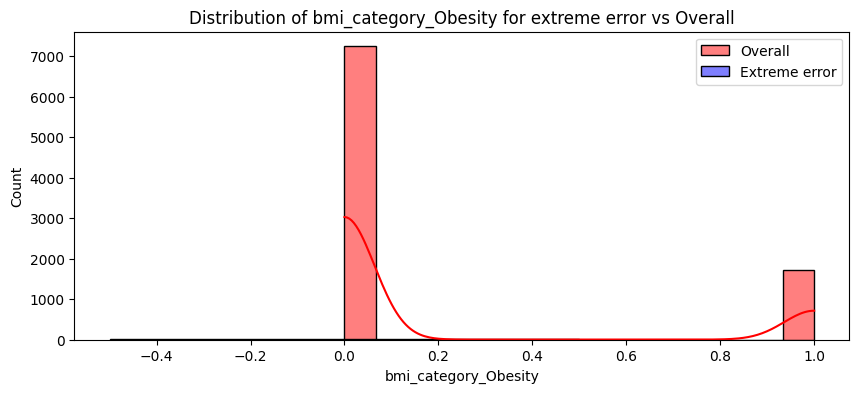

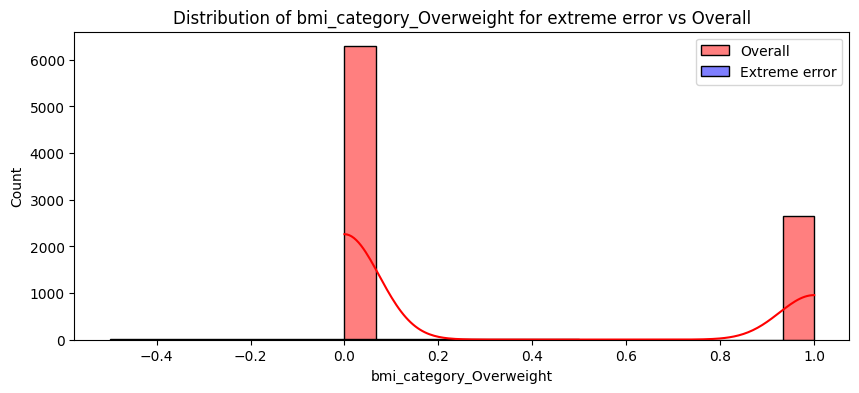

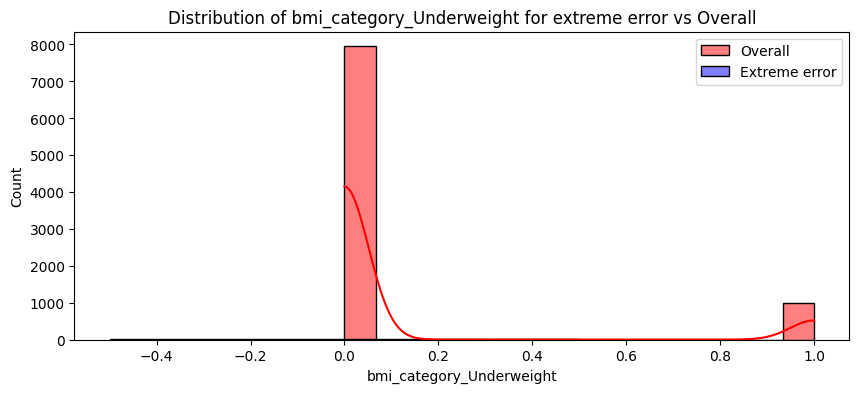

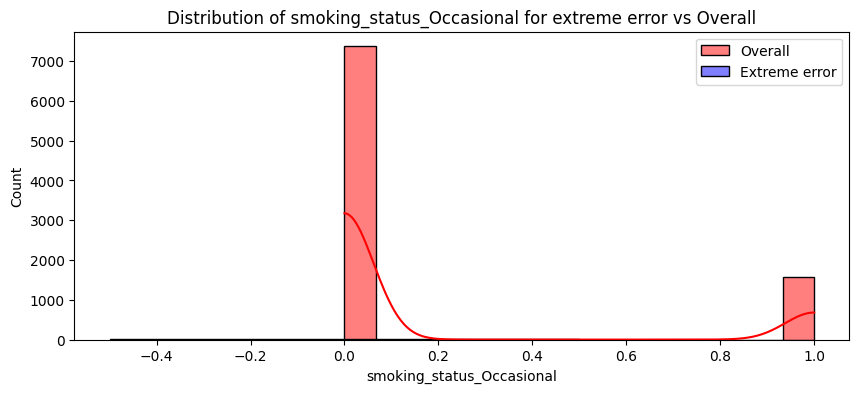

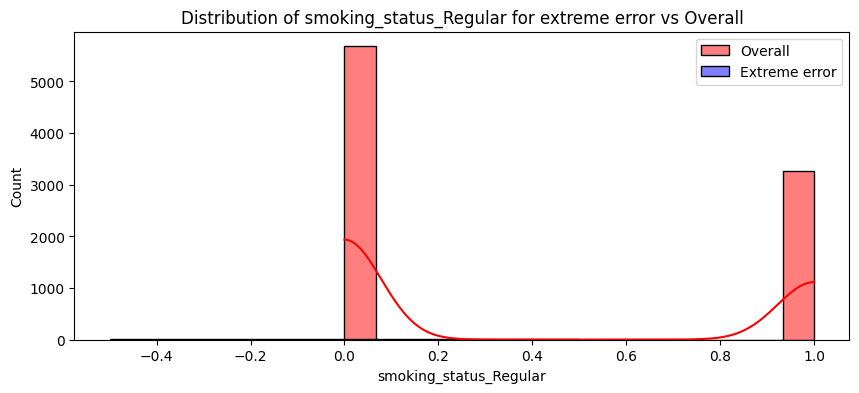

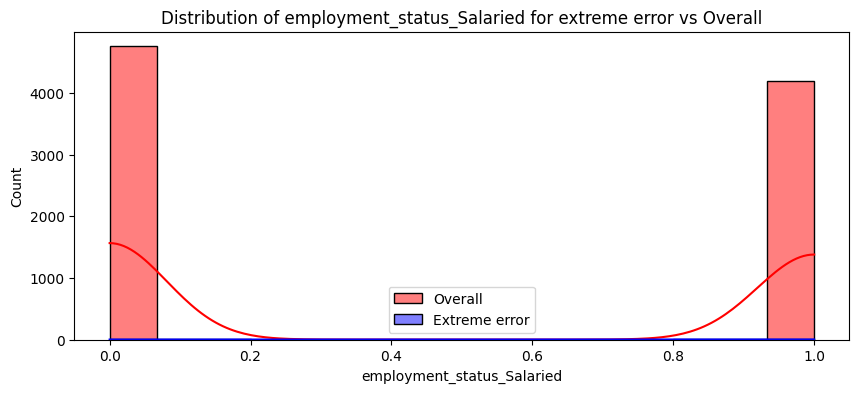

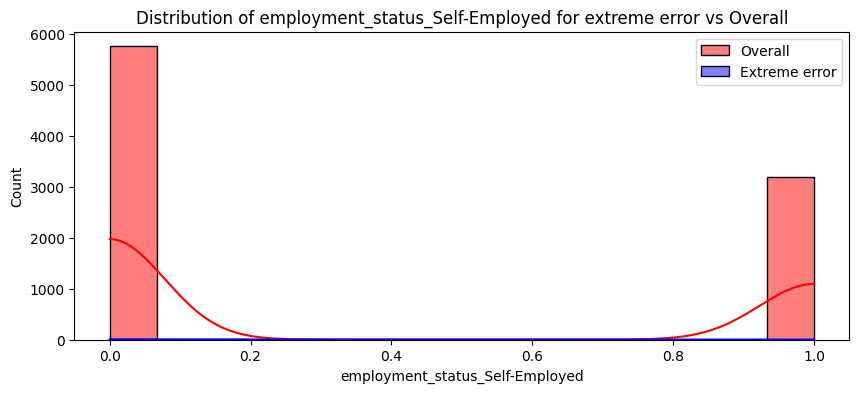

In [76]:
for feature in X_test.columns:
  plt.figure(figsize=(10, 4))
  sns.histplot(X_test[feature], color='red', label="Overall", kde=True)
  sns.histplot(extreme_errors_df[feature], color='blue', label="Extreme error", alpha=0.5, kde=True)
  plt.title(f'Distribution of {feature} for extreme error vs Overall')
  plt.legend()
  plt.show()



> age has some error, error_data is centric towards lower_age_group. We have to scale back to see the accurate age value.



In [77]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan',
 'genetical_risk']

In [78]:
extreme_errors_df['income_level']=-1

we have to initialize income_level to perform inverse_scaaling, because we have dropped the column while performing "VIF".

<Axes: xlabel='age', ylabel='Count'>

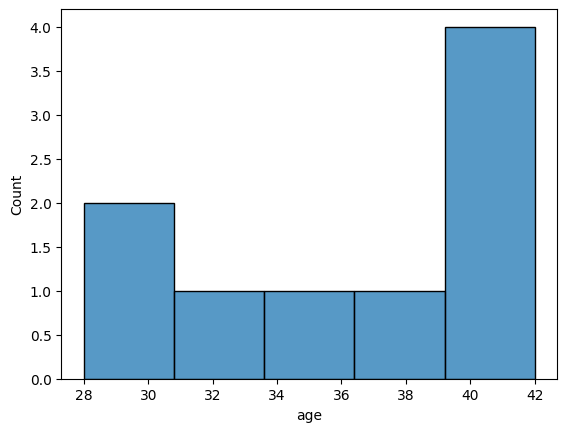

In [79]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed['age'])

In [80]:
df_reversed['age'].quantile(0.97)

np.float64(41.519999999999996)

In [81]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan',
 'genetical_risk']

In [82]:
from joblib import dump

dump(best_model, "/content/drive/MyDrive/Healthcare_premium_pred/model_rest.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(scaler_with_cols, "/content/drive/MyDrive/Healthcare_premium_pred/scaler_rest.joblib")

['/content/drive/MyDrive/Healthcare_premium_pred/scaler_rest.joblib']